# Video-level Anomaly Detection on UCF-Crime Dataset

This notebook outlines a weakly-supervised anomaly detection method designed for video-level anomaly detection tasks. To evaluate the effectiveness of this approach, we utilize the benchmark UCF-Crime dataset, a widely recognized dataset that has been extensively employed in various prior research studies.

The notebook is structured as follows:

* [Environment Setup and Imports](#chapter1)
* [Global variables and argument parsing](#chapter2)
* [UCF-Crime Dataset](#chapter3)
    * [Train Data Loading](#section_3_1)
    * [Test Data Loading](#section_3_2)
* [Weakly Supervised Video Anomaly Detection Methods](#chapter3)
    * [Model Architecture](#section_3_1)
    * [Model Configuration](#section_3_1)
        * [Model Instantiation](#sub_section_3_1_1)
        * [Optimizer](#sub_section_3_1_2)
        * [Learning Rate Scheduler ](#sub_section_3_1_1)
        * [Criterion](#sub_section_3_1_2)
    * [Model Training ](#section_3_1)
    * [Model Evaluation](#section_3_1)
   
   

# 1. Environment Setup and Imports
In this initial step, we commence by importing the required packages for our experiments. 

In [42]:
import os
import torch
from torch.utils.data import DataLoader
from numpy import argmax
from sklearn import metrics
import matplotlib.pyplot as plt
import argparse
from learner import Learner
from loss import *
from dataset import *

# 2. Global variables and argument parsing

In [43]:
# Declare best_auc (area under curve) as a global variable
best_auc = 0

In this notebook, we utilize the `argparse` library to interpret command-line arguments for configuring the PyTorch MIL (Multiple Instance Learning) training process. Command-line arguments serve as a means to fine-tune various parameters without the necessity of direct code modifications.

Below, you'll find a list of the available arguments along with their default values:

--lr: Learning rate (default: 0.001) 

--w: Weight decay (default: 0.0010000000474974513)

--modality: Modality (default: 'TWO')

--input_dim: Input dimension (default: 2048)

--drop: Dropout rate (default: 0.6)

These arguments offer the flexibility to be tailored to your specific requirements when executing the script. For instance, should you wish to adjust the learning rate, you can do so by specifying --lr 0.01. Similarly, you can modify the input dimension with --input_dim 4096.

Regarding the modality argument, it pertains to the type of extracted features you intend to employ for model training. It is initially set to 'TWO,' signifying the concatenation of RGB and Flow features for training. If you opt to switch the modality to 'RGB' or 'FLOW,' which correspond to using only RGB or Flow features, respectively, you should also adjust the input_dim to 1024. This adjustment is necessary because we utilize a two-stream I3D network as a feature extractor, resulting in two 1024-dimensional tensors—one for RGB and one for Flow features. Setting input_dim to 2048 aligns with the 'TWO' modality, whereas switching to 'RGB' or 'FLOW' necessitates an input_dim of 1024 to properly account for the selected feature set's dimensions. This exploration allows you to assess the impact of your chosen features on the anomaly detection model's performance.

In [44]:
parser = argparse.ArgumentParser(description='PyTorch MIL Training')
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--w', default=0.0010000000474974513, type=float, help='weight_decay')
parser.add_argument('--modality', default='TWO', type=str, help='modality')
parser.add_argument('--input_dim', default=2048, type=int, help='input_dim')
parser.add_argument('--drop', default=0.6, type=float, help='dropout_rate')
args, unknown = parser.parse_known_args()

# 3. UCF-Crime Dataset


One of the most famouse large-scale dataset video anomaly detection dataset with video-level labels is [UCF-crime](https://www.crcv.ucf.edu/projects/real-world/) dataset that contains 1,900 untrimmed real-world outdoor and indoor surveillance videos. The total length of the videos is 128 hours, which contains 13 classes of anomalous events including: 1. Abuse, 2. Arrest, 3. Arson, 4. Assault, 5. Burglary, 6. Explosion, 7. Fighting, 8. Road Accident, 9. Robbery, 10. Shooting, 11. Stealing, 12. Shoplifting, 13. Vandalism.

The UCF-Crime dataset consists of 1900 surveillance videos, with the training set consisting
of 800 normal videos and 810 abnormal videos. The testing set includes 150 normal videos
and 140 anomaly videos, covering all 13 anomaly categories in both sets. Here are a few exemplars from the dataset:



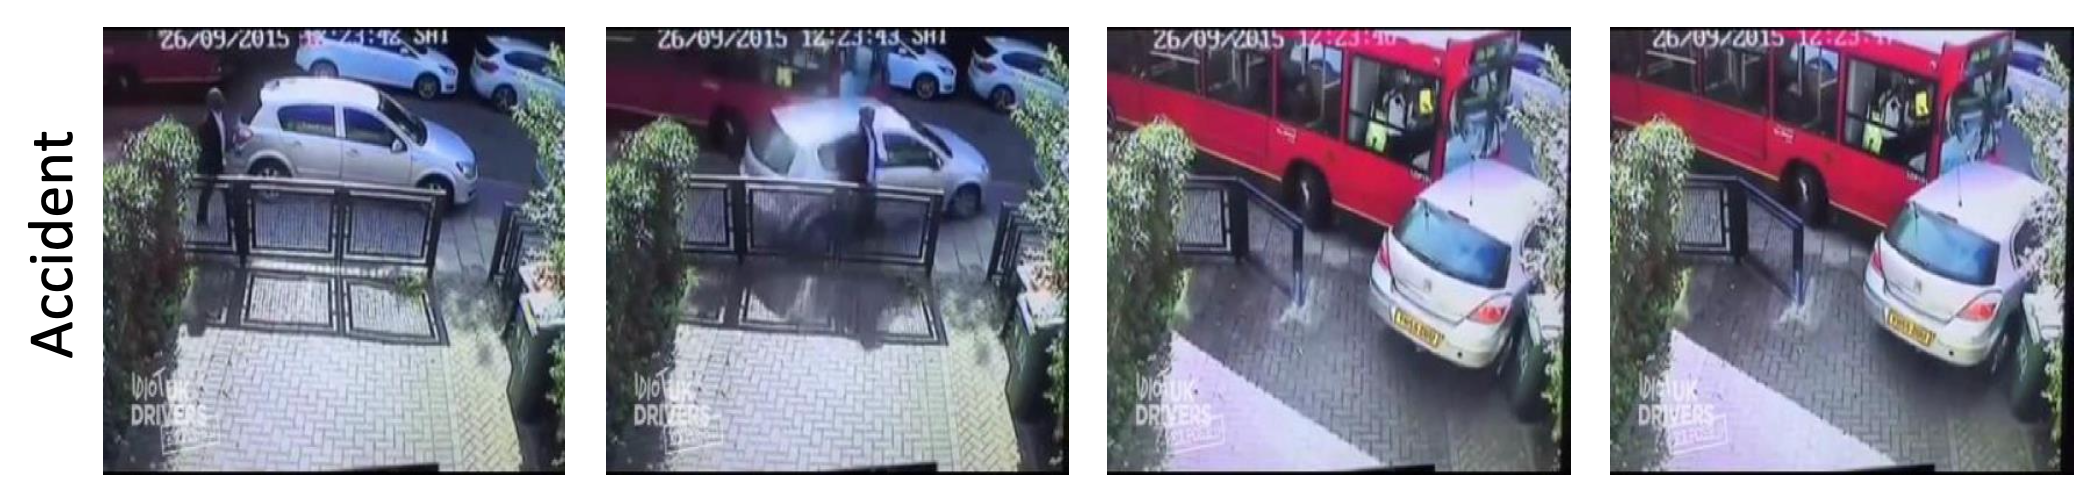

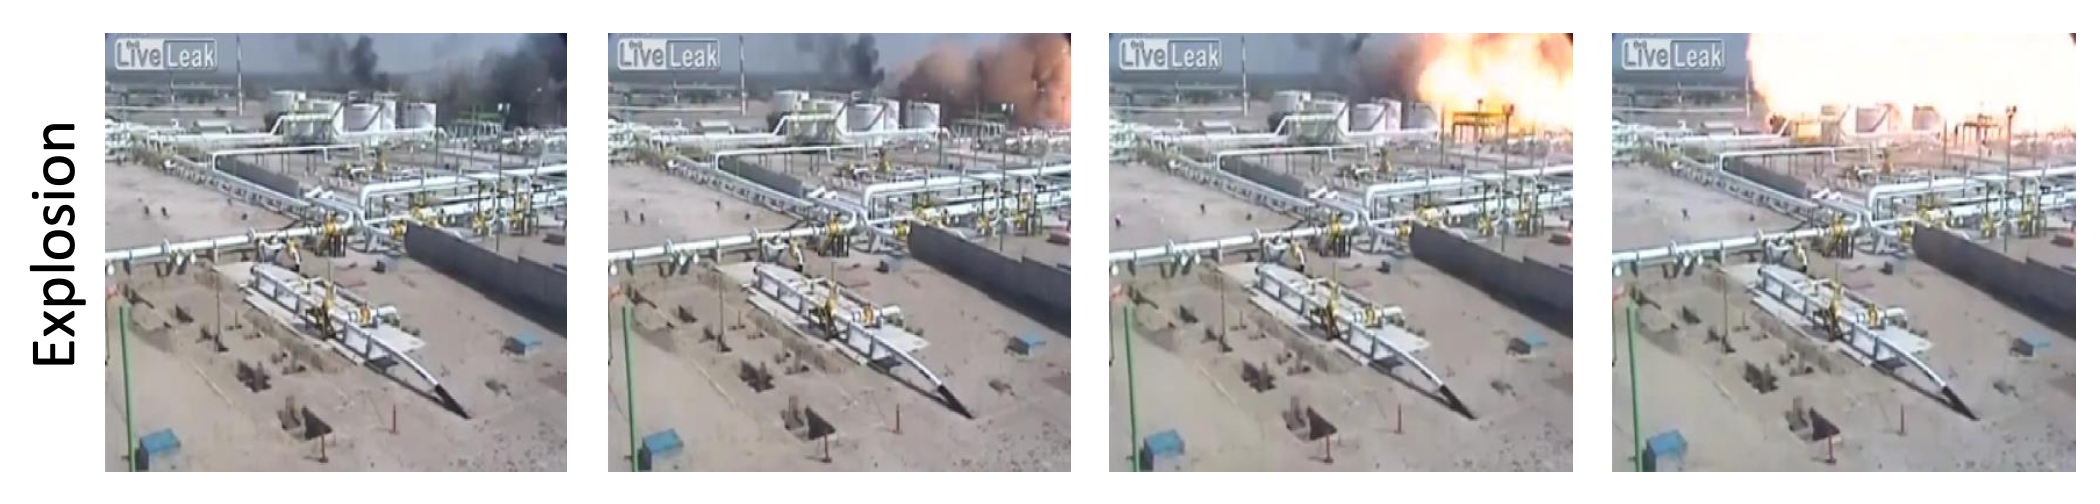

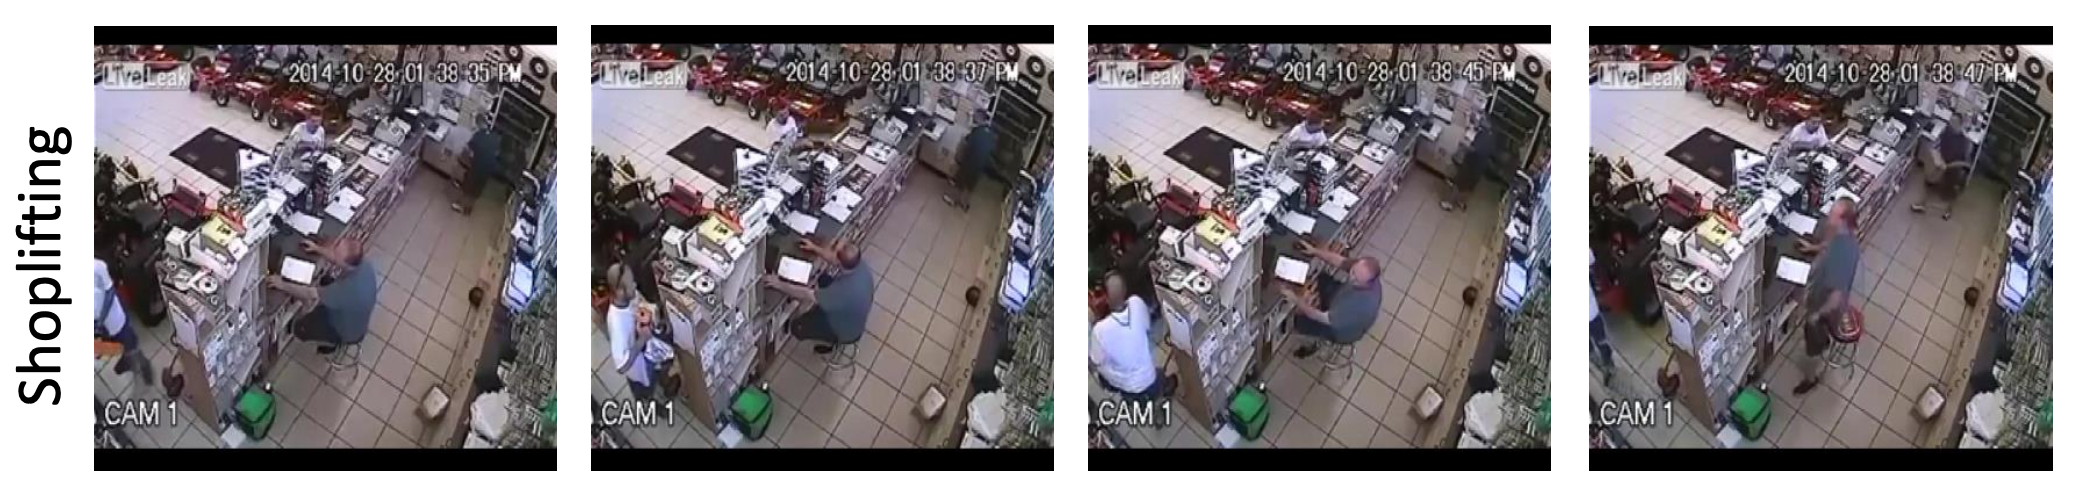

## 3.1. Train Data Loading
To perform the training, we utilize extracted features (RGB and Flow) from both normal and abnormal videos. The training dataset comprises 800 typical videos and 810 atypical videos.

In [45]:
normal_train_dataset = Normal_dataset(is_train=1, modality=args.modality)
anomaly_train_dataset = Abnormal_dataset(is_train=1, modality=args.modality)
normal_train_loader = DataLoader(normal_train_dataset, batch_size=30, shuffle=True)
anomaly_train_loader = DataLoader(anomaly_train_dataset, batch_size=30, shuffle=True)

## 3.2. Test Data Loading
The testing set includes 150 normal videos and 140 anomaly videos, covering all 13 anomaly categories in both normal and abnormal sets.

In [46]:
normal_test_dataset = Normal_dataset(is_train=0, modality=args.modality)
anomaly_test_dataset = Abnormal_dataset(is_train=0, modality=args.modality)
normal_test_loader = DataLoader(normal_test_dataset, batch_size=1, shuffle=True)
anomaly_test_loader = DataLoader(anomaly_test_dataset, batch_size=1, shuffle=True)

Determine the count of test and train videos for future use in assessing the model.

In [47]:
#Calculate the number of test and train videos for further use in evaluating the model
num_test_files = anomaly_test_dataset.__len__()
num_train_files = normal_train_dataset.__len__()

# 4. Weakly Supervised Video Anomaly Detection Methods
The weakly-supervised video anomaly detection assumes that video-level normal/anomaly labels are given for training. Compared to the unsupervised video anomaly detection, obtaining such video-level labels requires more human effort however compared to usupervised methods, weakly supervised paradigm offers several advantages:

1. Weak supervision only requires video-level annotations, where the presence of anomalous events is indicated, but their start and end locations are unknown which allows for the construction of large-scale datasets for anomaly detection.
2. The presence of both normal and abnormal samples and their annotation enables the model to learn more discriminative representations to improve its performance on large-scale datasets.

In this notebook, we will delve into implementing a weakly-supervised anomaly detection method based on the two-stream I3D convolution network. The list of state-of-the-art weakly supervised video anomaly detection methods and their repositary in the below for self-exploration over UCF-Crime dataset:

- Learning Prompt-Enhanced Context Features for Weakly-Supervised Video Anomaly Detection: https://github.com/yujiangpu20/PEL4VAD
- Unbiased Multiple Instance Learning for Weakly Supervised Video Anomaly Detection: https://github.com/ktr-hubrt/umil
- Self-Supervised Sparse Representation for Video Anomaly Detection: https://github.com/louisYen/S3R


## 4.1. Model Architecture
We utilize a two-stream Inflated 3D (I3D) Convolutional Network to extract RGB and Flow features from the video. The RGB stream extracts information related to the appearance of objects and scenes, while the optical Flow stream captures the motion and dynamics of objects between frames. We then combined the information from both streams by concatenating the learned RGB and Flow features. This provides a more complete understanding of the video content, leading to improved anomaly detection accuracy. To avoid annotating abnormal activities in training videos, a weakly supervised anomaly detection model was implemented based on the Multiple Instance Learning (MIL) framework. The model considers normal and abnormal videos as bags and video clips as instances. It learns a ranking model to predict high anomaly scores for video clips containing anomalies.

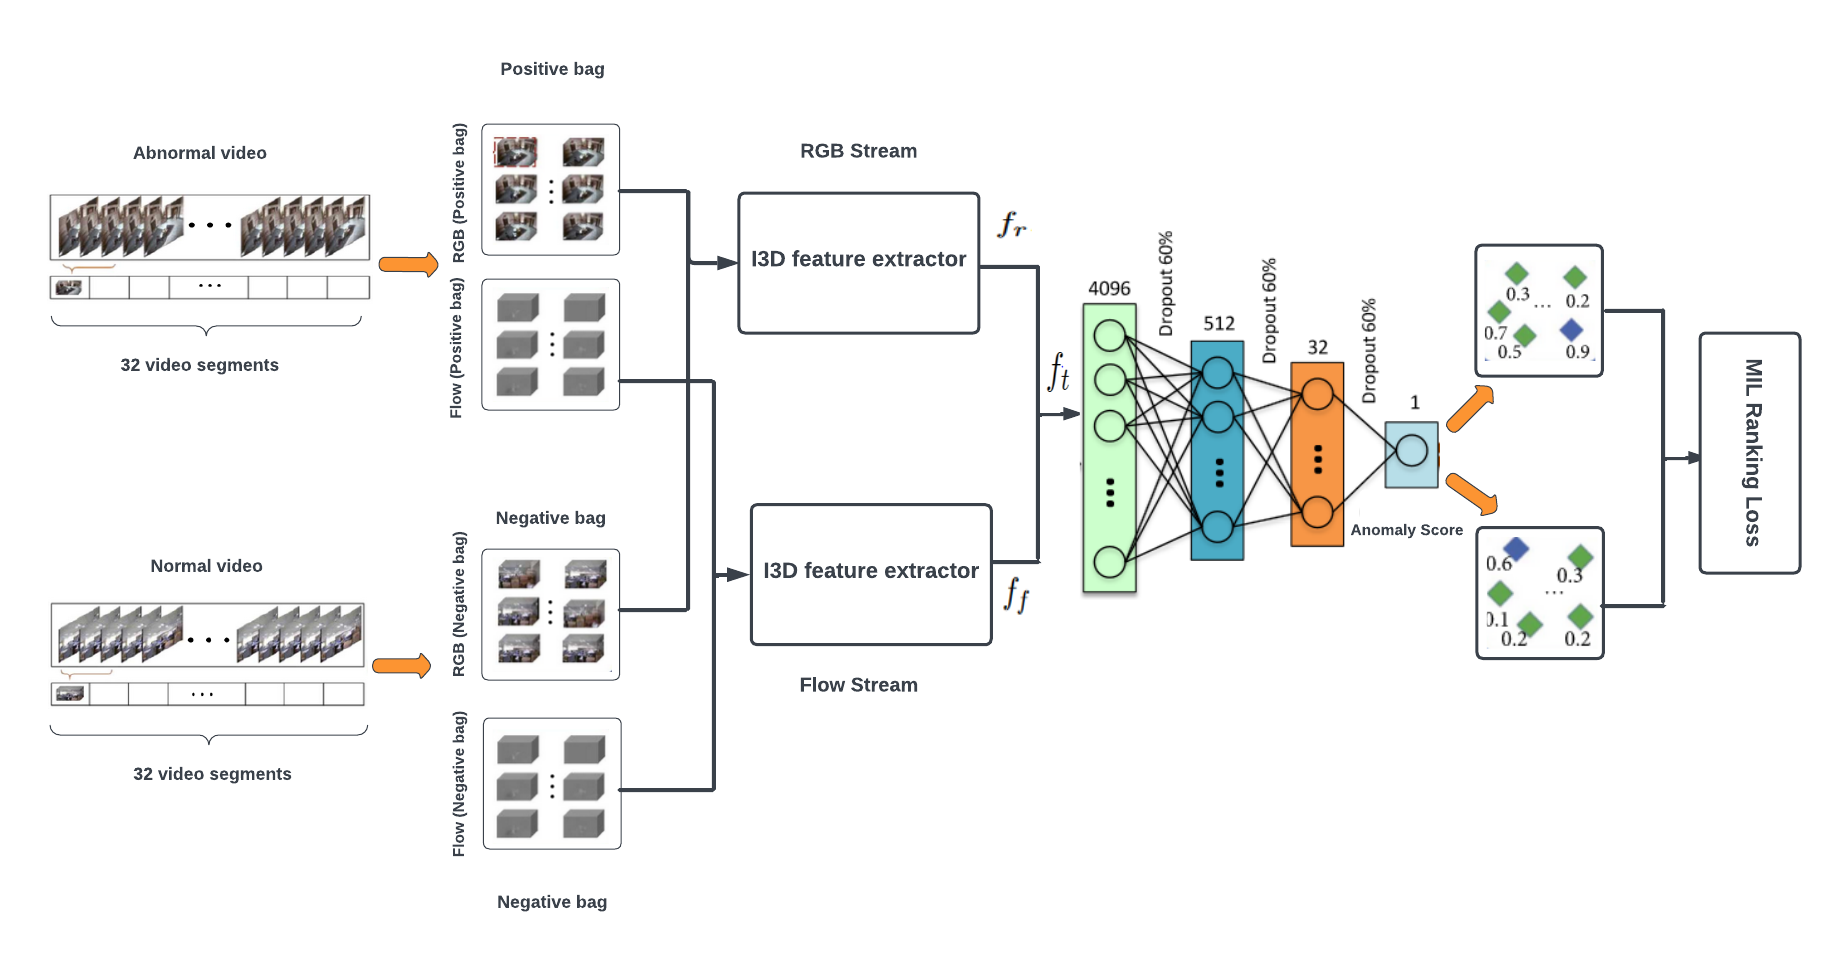

## 4.2. Model Configuration


In this section, we configure the model and its associated components for the PyTorch MIL training.

- `model = Learner(input_dim=args.input_dim, drop_p=args.drop).to(device)`: We create the model for MIL training using the `Learner` class. The `input_dim` parameter is set based on the chosen input dimensionality, as specified in the command-line arguments. Additionally, the `drop_p` parameter determines the dropout rate for the model. The `.to(device)` method ensures that the model is placed on the appropriate hardware, whether it's a GPU ('cuda') or CPU ('cpu').

- `optimizer = torch.optim.Adagrad(model.parameters(), lr=args.lr, weight_decay=args.w)`: Here, we define the optimizer, specifically using the Adagrad optimizer, for updating the model's parameters during training. The learning rate (`lr`) and weight decay (`weight_decay`) are set based on the provided command-line arguments, allowing for easy adjustment of optimization settings.

- `scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50])`: We create a learning rate scheduler using the MultiStepLR scheduler. This scheduler adjusts the learning rate at specific milestones during training. In this case, the milestones are set to occur at epochs 25 and 50, enabling adaptive learning rate changes as the training progresses.

- `criterion = MIL`: Lastly, the `criterion` variable is initialized, representing the loss function for the training process. The specifics of the MIL (Multiple Instance Learning) loss function are defined in the `loss.py` module.

These configuration steps are crucial for setting up the model and its training parameters, allowing for effective training and optimization of the anomaly detection model.


### 4.2.1. Model Instantiation
We create an instance of the `Learner` model, which is the core architecture of our MIL model. We specify two parameters:
   - `input_dim`: This parameter controls the input dimension of the model. Its value is determined by the `--input_dim` argument passed when running the script, allowing us to adjust the input dimension as needed.
   - `drop_p`: This parameter represents the dropout rate, which influences the model's regularization. Its value is determined by the `--drop` argument provided during script execution.

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Learner(input_dim=args.input_dim, drop_p=args.drop).to(device)

### 4.2.2. Optimizer

We set up the model's optimizer for the training process. Specifically, we employ the Adagrad optimizer, which is well-suited for scenarios involving sparse data. The essential parameters are adjusted as follows:

lr: The learning rate is determined by the value passed via the --lr argument. This enables us to finely adjust the learning rate as needed throughout the training process.
weight_decay: We introduce weight decay regularization by specifying the value obtained from the --w argument. This regularization technique is implemented to enhance the model's generalization capability.
You have the option to explore alternative optimizers such as Adam as part of the hyperparameter tuning process. This experimentation can help determine the most suitable optimizer for your specific training scenario.

In [49]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=args.lr, weight_decay=args.w)

### 4.2.3. Learning Rate Scheduler 
A learning rate scheduler is employed to adapt the learning rate throughout training. In this case, we use a multi-step learning rate scheduler with milestones at epochs 25 and 50, which are defined by the `milestones` parameter. Adjusting the learning rate at these milestones can be crucial for optimizing model convergence.


In [50]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50])

### 4.2.4. Criterion
the `criterion` variable is initialized, representing the loss function for the training process. The specifics of the MIL (Multiple Instance Learning) loss function are defined in the `loss.py` module. The ranking loss between the top-scoring instances in the positive bag and the negative bag is computed using the hinge-loss function.

In [51]:
criterion = MIL

By configuring these components, we establish the foundation for training our MIL model, allowing us to adapt the model architecture, optimization strategy, and loss function based on our experimental requirements.

## 4.3. Model Training
In this section, we define the train_one_epoch function, a pivotal component of our anomaly detection model's training process. This function is responsible for conducting one complete training epoch, during which the model is set to training mode, and both normal and anomaly data are processed in batches. The inputs from both loaders are concatenated and reshaped to match the model's input requirements. The model computes predictions, and the loss is calculated using a designated criterion, which in this case is the MIL (Multiple Instance Learning) loss. Gradients are then computed through backpropagation, and model parameters are updated using the optimizer. The function also accumulates the epoch's loss and adjusts the learning rate with a scheduler. The returned train_loss represents the average training loss for the entire epoch.

In [52]:
def train_one_epoch(model, optimizer, scheduler, criterion, normal_train_loader, anomaly_train_loader, device):
    model.train()
    epoch_loss = 0
    for batch_idx, (normal_inputs, anomaly_inputs) in enumerate(zip(normal_train_loader, anomaly_train_loader)):
        inputs = torch.cat([anomaly_inputs, normal_inputs], dim=1)
        batch_size = inputs.shape[0]
        inputs = inputs.view(-1, inputs.size(-1)).to(device)
        outputs = model(inputs)
        itr_loss = criterion(outputs, batch_size)
        epoch_loss += itr_loss.item()
        optimizer.zero_grad()
        itr_loss.backward()
        optimizer.step()
    train_loss = epoch_loss / len(normal_train_loader)
    scheduler.step()
    return train_loss

## 4.4. Model Evaluation

To assess the performance of our anomaly detection model, we rely on the Area Under the Curve (AUC) obtained from the Receiver Operating Characteristic (ROC) curve. This metric is a well-established and widely adopted measure in the field of video anomaly detection. It provides valuable insights into the model's ability to distinguish between normal and anomalous video segments.

We calculate the AUC-ROC score using the `compute_auc` function, which takes into account the ground truth labels. This evaluation process allows us to quantitatively measure the model's performance across all test datasets. The higher the AUC-ROC score, the better the model's ability to correctly identify anomalies.

In [53]:
def compute_auc(gts, pred):
    fpr, tpr, thresholds = metrics.roc_curve(gts, pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return auc


In this section, we introduce the test function for evaluating our anomaly detection model's performance. This function calculates the Area Under the Curve (AUC) for Receiver Operating Characteristic (ROC) curves
. It accomplishes this by processing pairs of abnormal and normal video data, extracting ground truth labels and frames information, computing anomaly scores, segmenting videos into 16-frame segments, and aggregating AUC values. The function also saves the model's state if the calculated AUC surpasses the current best AUC.

In [54]:
def test_abnormal(model, anomaly_test_loader, normal_test_loader):
    model.eval()
    global best_auc
    epoch_auc = 0
    with torch.no_grad():
        for i, (data, data2) in enumerate(zip(anomaly_test_loader, normal_test_loader)):
            inputs, gts, frames = data  #Extract ground truths and frames info
            inputs = inputs.view(-1, inputs.size(-1)).to(torch.device('cuda'))
            score = model(inputs)  # Assigning anomaly score to the given videos
            score = score.cpu().detach().numpy()
            score_list = np.zeros(frames[0])
            step = np.round(np.linspace(0, frames[0] // 16, 33))  
            for j in range(32):
                score_list[int(step[j]) * 16:(int(step[j + 1])) * 16] = score[j] #Passing the assigned anomaly score to the 16 frames containing each video instance
            gt_list = np.zeros(frames[0])
            for k in range(len(gts) // 2):
                s = gts[k * 2]
                e = min(gts[k * 2 + 1], frames)
                gt_list[s - 1:e] = 1
            inputs2, gts2, frames2 = data2
            inputs2 = inputs2.view(-1, inputs2.size(-1)).to(torch.device('cuda'))
            score2 = model(inputs2)
            score2 = score2.cpu().detach().numpy()
            score_list2 = np.zeros(frames2[0])
            step2 = np.round(np.linspace(0, frames2[0] // 16, 33))
            for kk in range(32):
                score_list2[int(step2[kk]) * 16:(int(step2[kk + 1])) * 16] = score2[kk]
            gt_list2 = np.zeros(frames2[0])
            score_list3 = np.concatenate((score_list, score_list2), axis=0)
            gt_list3 = np.concatenate((gt_list, gt_list2), axis=0)
            itr_auc = compute_auc(gt_list3, score_list3)
            epoch_auc += itr_auc
        test_auc = epoch_auc / len(anomaly_test_loader)
        print('test_auc =', test_auc)
        if best_auc < test_auc:
            print('Saving..')
            state = {
                'net': model.state_dict(),
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_auc = test_auc
    print("best auc =", best_auc)

We train and evaluate the model over 75 epochs. Note that you have the flexibility to train the model for more epochs to observe potentially improved results. Adjusting the number of training epochs allows for further exploration of the model's performance and learning dynamics.

In [55]:
for epoch in range(0, 75):
    train_loss = train_one_epoch(model, optimizer, scheduler, criterion, normal_train_loader, anomaly_train_loader, device)
    print(f'Epoch {epoch}: train_loss = {train_loss:.4f}',)
    test_abnormal(model, anomaly_test_loader, normal_test_loader)


Epoch 0: train_loss = 0.9572
test_auc = 0.8164108784206139
Saving..
best auc = 0.8164108784206139
Epoch 1: train_loss = 0.8883
test_auc = 0.8060310125512485
best auc = 0.8164108784206139
Epoch 2: train_loss = 0.8355
test_auc = 0.8138852952605261
best auc = 0.8164108784206139
Epoch 3: train_loss = 0.7969
test_auc = 0.8100687964874388
best auc = 0.8164108784206139
Epoch 4: train_loss = 0.7633
test_auc = 0.807619414082747
best auc = 0.8164108784206139
Epoch 5: train_loss = 0.7275
test_auc = 0.8162092948921581
best auc = 0.8164108784206139
Epoch 6: train_loss = 0.6928
test_auc = 0.8235071610347723
Saving..
best auc = 0.8235071610347723
Epoch 7: train_loss = 0.6692
test_auc = 0.823364344787098
best auc = 0.8235071610347723
Epoch 8: train_loss = 0.6449
test_auc = 0.8206331981151073
best auc = 0.8235071610347723
Epoch 9: train_loss = 0.6155
test_auc = 0.8320876046650797
Saving..
best auc = 0.8320876046650797
Epoch 10: train_loss = 0.5989
test_auc = 0.8254333484787663
best auc = 0.832087604665